In [187]:
# import importlib
# %load_ext autoreload
# %reload_ext autoreload
# %autoreload 2
from patchify import patchify
from Common_Functions.CommonFunctions import *
from sklearn.neighbors import NearestNeighbors
# from color_transfer import color_transfer
# from segmentation.FaceDetectionSegmentation import segement
import cv2
from skimage.transform import pyramid_gaussian
import imageio.v3 as iio
from Optimization_Functions.pca import pca
from Optimization_Functions.irls import irls 
import Optimization_Functions.PatchMatching as pm
import Optimization_Functions.segmentation as seg
import color_transfer as ct

import importlib
importlib.reload(pm)
importlib.reload(seg)
importlib.reload(ct)

<module 'color_transfer' from 'D:\\ip_project\\style-transfer\\color_transfer.py'>

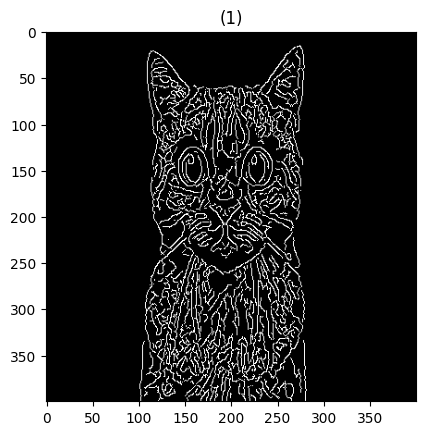

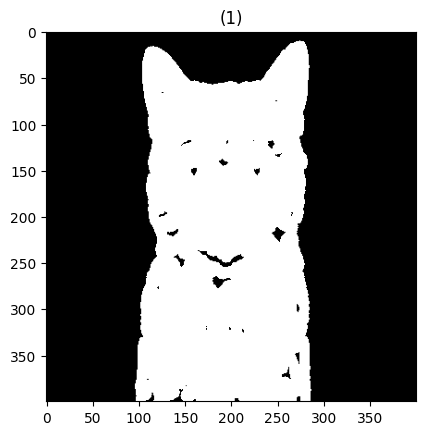

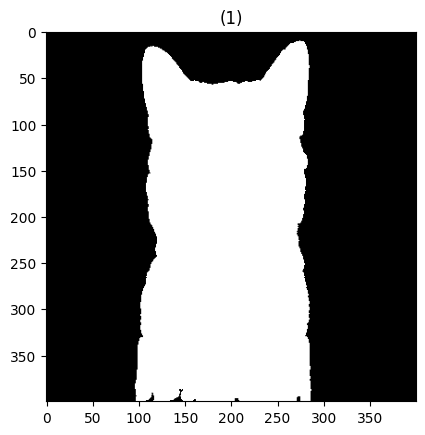

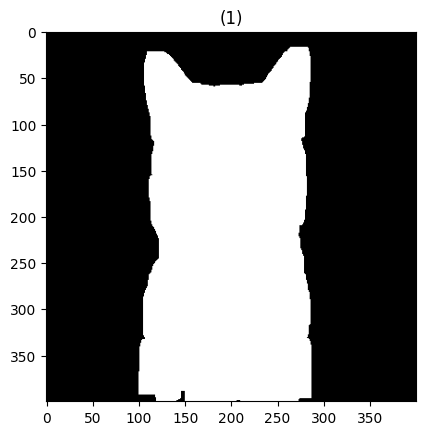

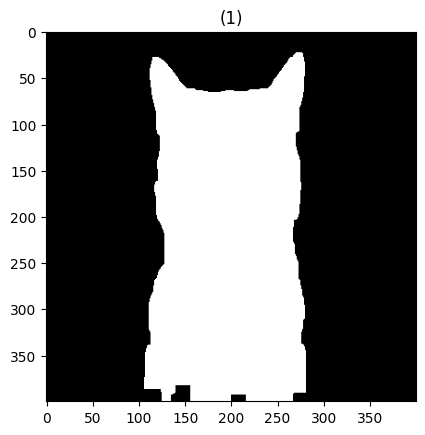

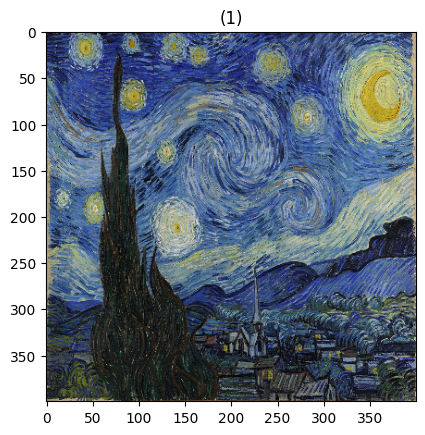

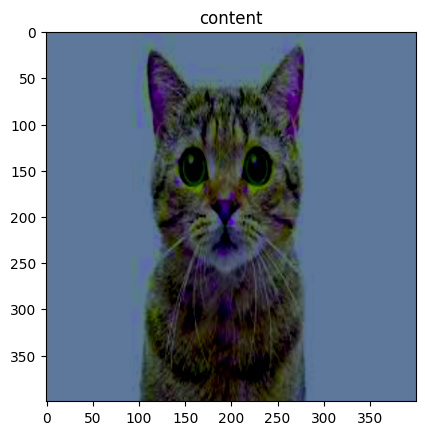

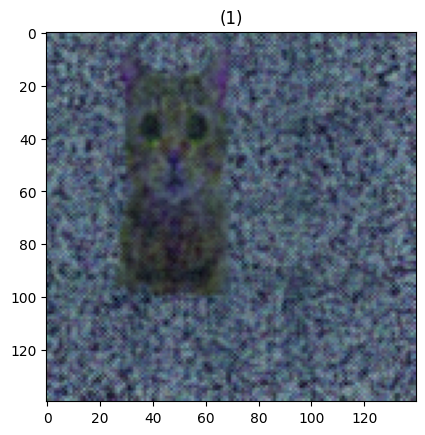

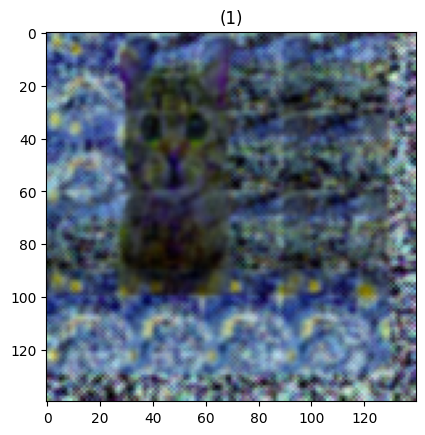

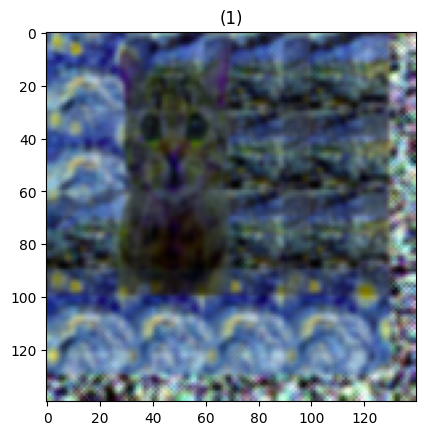

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


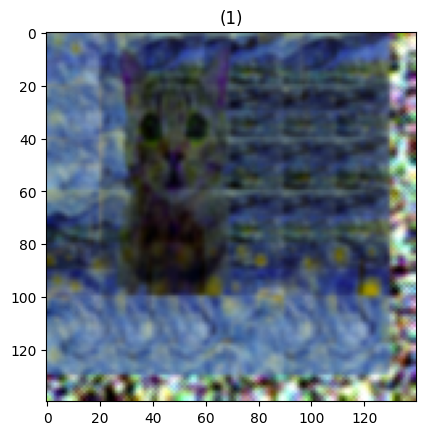

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


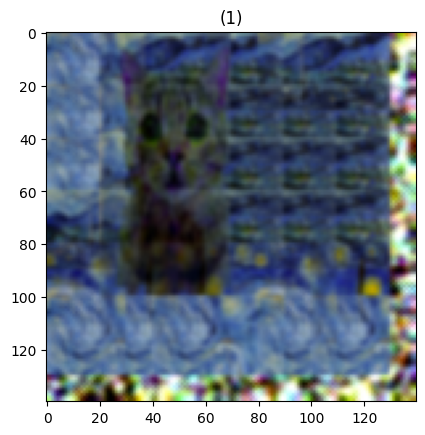

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


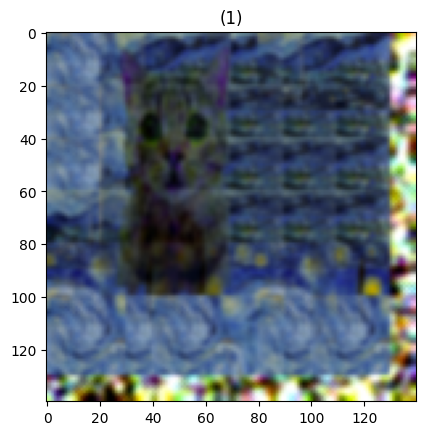

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


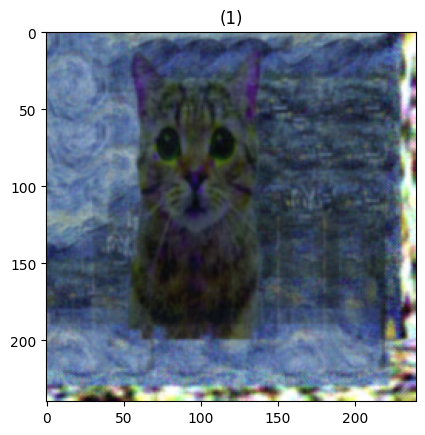

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


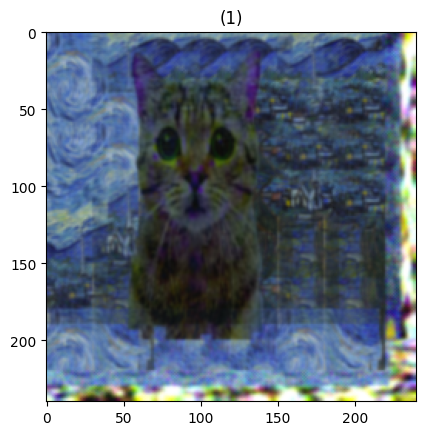

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


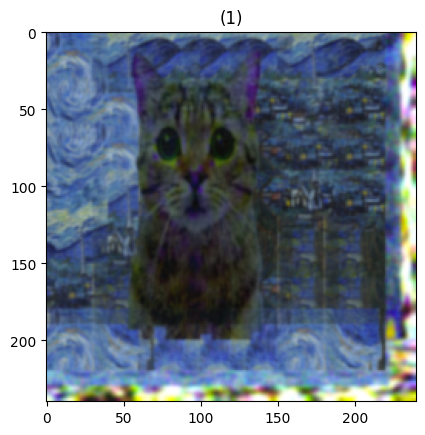

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


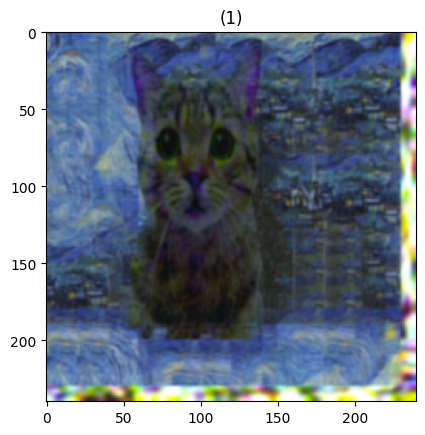

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


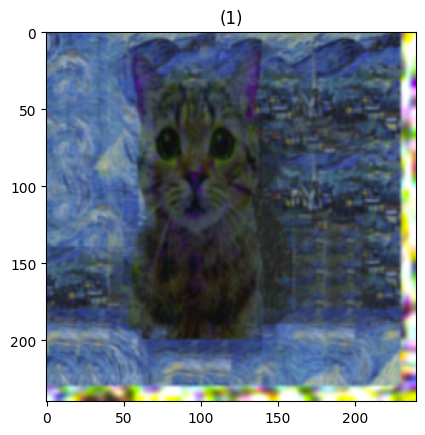

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


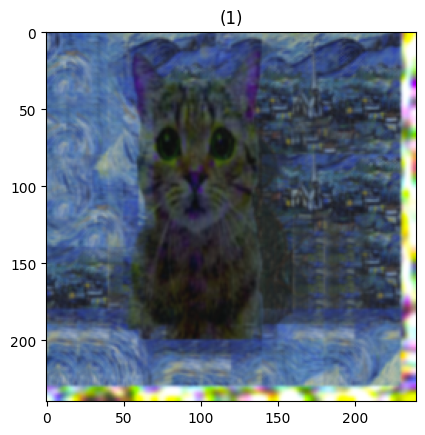

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


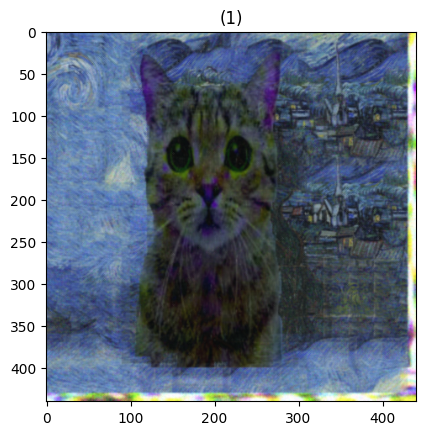

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


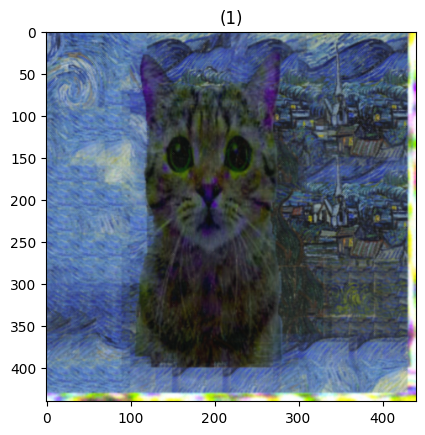

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


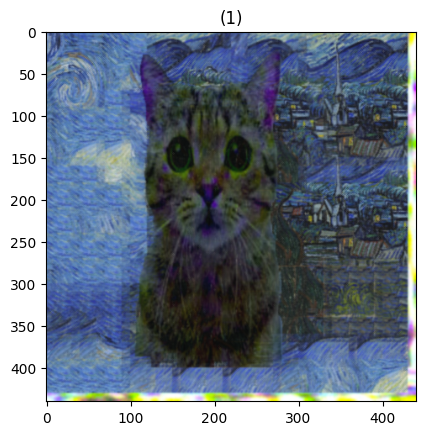

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


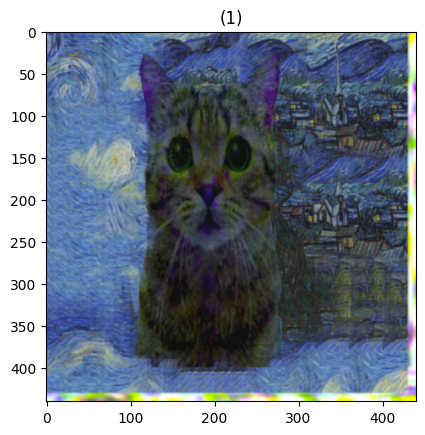

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


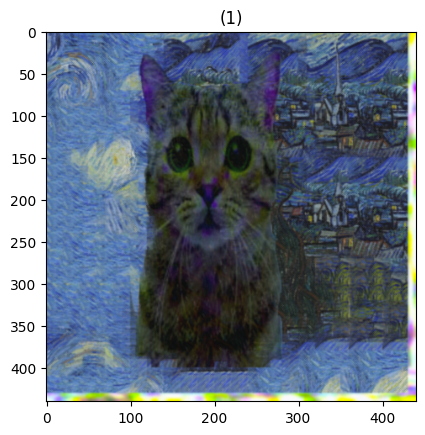

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


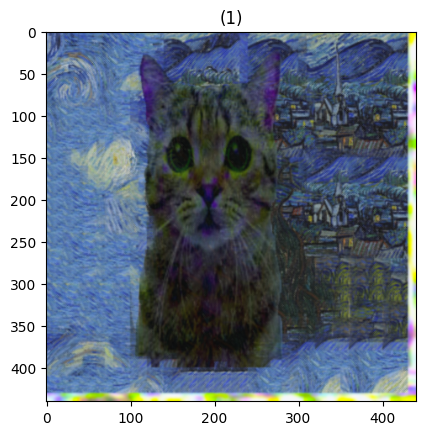

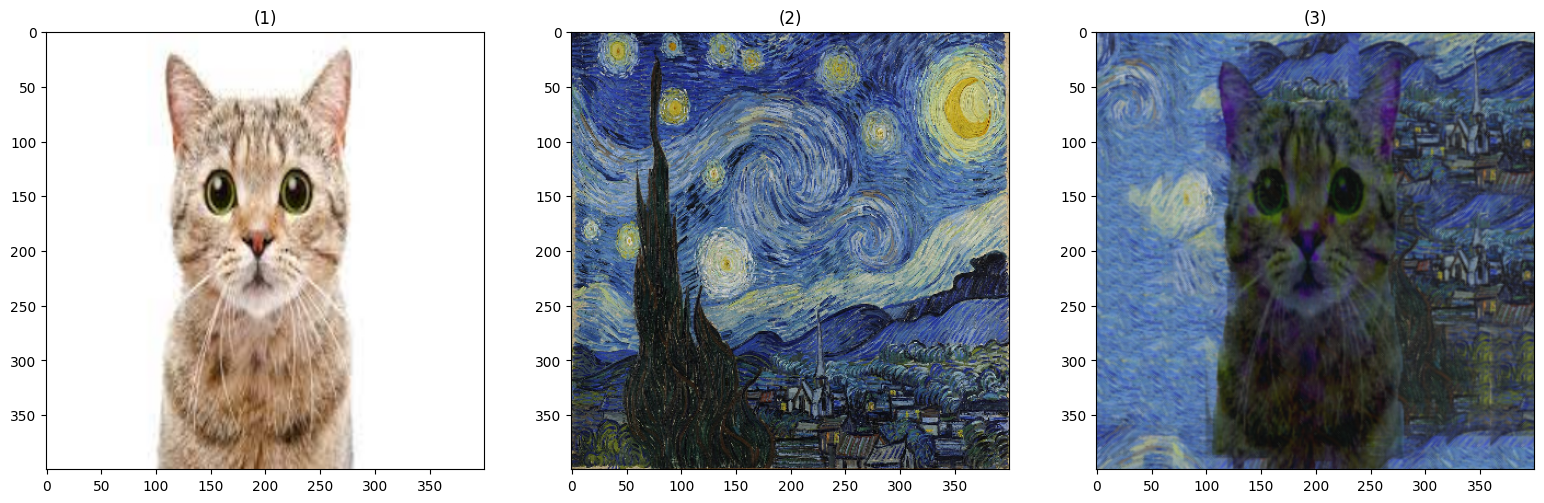

In [198]:
def style_transfer(content, style, r, L, Iirls, patch_sizes, subsampling_gaps, Ialg, seg_mask,color_transfer_type='histogram'):
    # apply color_transfer from the style to the content 
    # color_transfer_type -> 'histogram' applies match_histograms color transfer
    # color_transfer_type -> 'lab' applies lab color transfer
    # lab color transfer is better for less colorful images
    content = ct.color_transfer(content,style, color_transfer_type)
    show_images([content],["content"])
    
    # build gaussian pyramids
    content_pyramid_tuple = tuple(pyramid_gaussian(content, channel_axis=-1, max_layer=L, downscale=2))
    style_pyramid_tuple = tuple(pyramid_gaussian(style, channel_axis=-1, max_layer=L, downscale=2))
    w_pyramid_tuple = tuple(pyramid_gaussian(seg_mask, channel_axis=-1, max_layer=L, downscale=2))
    content_pyramid = []
    style_pyramid = []
    w_pyramid = []
    for i in range (0,L):
        content_pyramid.append(content_pyramid_tuple[i])
        style_pyramid.append(style_pyramid_tuple[i])
        w_pyramid.append(w_pyramid_tuple[i])
        
    X = np.copy(content_pyramid[L-1])
    X = np.pad(X, ((0, patch_sizes[0]), (0, patch_sizes[0]), (0, 0)), mode='reflect')
    resized_style = cv2.resize(style, (np.shape(X)[1],np.shape(X)[0]))
    
    # apply the style to the padding
    X[-patch_sizes[0]:np.shape(X)[0], :, :] = resized_style[-patch_sizes[0]:np.shape(X)[0], :, :]
    X[:-patch_sizes[0], -patch_sizes[0]:, :] = resized_style[:-patch_sizes[0], -patch_sizes[0]:, :]

    for l in range (L-1,-1,-1):
        if l == L-1:
            X= random_noise(X, mode="gaussian",mean=0,var=50)
        else:
            X= random_noise(X, mode="gaussian",mean=0,var=0.01)
        content_pyramid[l] = np.pad(content_pyramid[l], ((0, patch_sizes[0]), (0, patch_sizes[0]), (0,0)), mode='constant', constant_values=(0,0))
        w_pyramid[l] = np.pad(w_pyramid[l], ((0, patch_sizes[0]), (0, patch_sizes[0]), (0, 0)), mode='constant', constant_values=(0,0))
        for s in range(0,len(patch_sizes)):
            style_patches =  patchify(style_pyramid[l],(patch_sizes[s], patch_sizes[s], 3),subsampling_gaps[s])
            flatten_style_patches = style_patches.reshape(-1, patch_sizes[s] * patch_sizes[s] * 3)
            projection_matrix = []
            
            # apply pca if the patch size is less than 17
            if (patch_sizes[s]<17):
                flatten_style_patches, projection_matrix = pca(flatten_style_patches)
            
            # train the nearest neighbour model
            nn_model = NearestNeighbors(n_neighbors=2).fit(flatten_style_patches)
            
            for k in range(0,Ialg):
                # z is the matched style patches
                z=[]
                Xp=patchify(X,(patch_sizes[s], patch_sizes[s], 3),subsampling_gaps[s])
                flatten_Xp = Xp.reshape(-1, patch_sizes[s] * patch_sizes[s] * 3)
                
                # apply pca if the patch size is less than 17 using the projection matrix from the style patches
                if(patch_sizes[s]<17):
                    flatten_Xp = flatten_Xp - np.mean(flatten_Xp)
                    flatten_Xp = np.matmul(flatten_Xp, projection_matrix.T)
                    
                # Patch Matching
                z = pm.patch_matching (flatten_Xp, patch_sizes[s], subsampling_gaps[s], flatten_style_patches, nn_model, Xp.shape)
                # Robust Aggregation
                irls(X,z,r,Iirls,(patch_sizes[s],patch_sizes[s],3),subsampling_gaps[s])
                # Color Transfer
                X = ct.color_transfer(X,style,color_transfer_type)
                # Content Fusion
                X =((1.0-w_pyramid[l])* X).astype(np.float32) + ((w_pyramid[l].astype(np.float32))*content_pyramid[l]).astype(np.float32)
                # Denoise
                X = cv2.bilateralFilter(X, 1, sigmaColor=5, sigmaSpace=10)

                show_images([X])
        if l>0:
            padding_down=cv2.resize(X[-patch_sizes[0]:np.shape(X)[0], :, :], (np.shape(content_pyramid[l-1])[1]+patch_sizes[0], patch_sizes[0]))
            padding_right = cv2.resize(X[:-patch_sizes[0], -patch_sizes[0]:, :], (patch_sizes[0], np.shape(content_pyramid[l-1])[0]))

            # remove the padding
            X = X[0:-patch_sizes[0], 0:-patch_sizes[0], :]
            # resize the image to the size of the next content layer
            X = cv2.resize(X, (np.shape(content_pyramid[l-1])[1], np.shape(content_pyramid[l-1])[0]))
            # add the padding to the resized image
            X = np.pad(X, ((0, patch_sizes[0]), (0, patch_sizes[0]), (0, 0)), mode='constant', constant_values=(1,1))
            # add the previous padding to the resized image
            X[-patch_sizes[0]:np.shape(X)[0], :, :] = padding_down
            X[:-patch_sizes[0], -patch_sizes[0]:, :] = padding_right
    return X

X=io.imread("imgs/content/vat.jpg").astype(np.float32)/255
X=cv2.resize(X, (400,400))
style=io.imread("imgs/style/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg").astype(np.float32)/255
con = io.imread("imgs/content/vat.jpg")
con=cv2.resize(con, (400,400))
seg_mask= seg.ghaith(con)
# seg_mask= seg.segement(con)
# seg_mask = io.imread("imgs/seg5.jpg").astype(np.float32)/255
# io.imsave("seg.jpg", seg_mask) 
iio.imwrite(uri="D:\ip_project\style-transfer\imgs\eagles_seg.jpg", image=(seg_mask*255).astype(np.uint8))
style = cv2.resize(style, (np.shape(X)[0], np.shape(X)[1]))
show_images([style])
patches_sizes = [40, 30]
sampling_gaps = [30, 20]
r = 1
L_max = 3
I_irls = 5
I_alg = 3
out = style_transfer(X,style,r,L_max,I_irls,patches_sizes,sampling_gaps,I_alg , seg_mask,'sdsd')
iio.imwrite(uri="imgs\output\content_styl40.jpg", image=(out[:-patches_sizes[0],:-patches_sizes[0],:]*255).astype(np.uint8))
show_images([X, style, out[:-patches_sizes[0],:-patches_sizes[0],:]])


In [ ]:
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin, remove_small_objects
from scipy import ndimage as ndi
# def segement1(image):
# 
#     mask = np.zeros(image.shape[:2], np.uint8)
#     backgroundModel = np.zeros((1, 65), np.float64)
#     foregroundModel = np.zeros((1, 65), np.float64)
# 
#     img_height=image.shape[0]
#     img_width= image.shape[1]
#     rectangle = (1,1,img_width,img_height)
# 
#     cv2.grabCut(image, mask, rectangle, backgroundModel, foregroundModel, 10, cv2.GC_INIT_WITH_RECT)
# 
#     mask_forground = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')
#     result_img = image * mask_forground[:, :, np.newaxis]
#     result_mask = np.where((result_img>0),1,0).astype(float)
# 
#     return result_mask

def segement1(image):
    # convert to gray
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    can = canny(gray, low_threshold=20, high_threshold=150)
    # can = remove_small_objects(can, 21)
    can2 =ndi.binary_fill_holes(can)
    return can, can2

from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.measure import find_contours
def region_filling (image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray=cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
    se=np.ones((11,11),np.uint8)
    se2=np.ones((3,3),np.uint8)
    # can = canny(gray, low_threshold=20, high_threshold=180).astype(int)*244

    can=cv2.Canny(gray,80,100)
    # can1=cv2.erode(can,se2,iterations=1)
    can2=cv2.dilate(can,se,iterations=3)
    can3=cv2.erode(can2,se,iterations=3)

    print(np.max(can))
    show_images([can,can2,can3])
    # create binary image
    # can = np.where((can>0),1,0).astype(float)
    # cnts = find_contours(can, 0.8)
    cnts, hierarchy = cv2.findContours(can3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(can,[c], -1, color=(255, 255, 255), thickness=cv2.FILLED)
    print(cnts)
    show_images([can])
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))
    opening = cv2.morphologyEx(can, cv2.MORPH_OPEN, kernel, iterations=2)
    show_images([opening])
    #show_images([can, opening])

con = io.imread("imgs/content/russia.jpg")
con=cv2.resize(con, (400,400))
img= region_filling(con)
# show_images([img])
